This code imports essential Python libraries for building, training, and evaluating deep learning models with PyTorch. It includes modules for creating neural networks (torch.nn), optimization (torch.optim), and data handling (Dataset, DataLoader). It also imports tools for image preprocessing and augmentation (torchvision.transforms, PIL, cv2), working with datasets (pandas, numpy), visualization (matplotlib, seaborn), model evaluation (sklearn.metrics), and dataset splitting (train_test_split). Additional utilities like os, zipfile, random, and tqdm are used for file handling, reproducibility, and progress tracking.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import cv2
import os
from tqdm import tqdm
import random
from PIL import Image
import zipfile
import os

These three lines set random seeds for PyTorch, NumPy, and Python’s built-in random module to 42. This ensures reproducibility, meaning that every time you run your code, operations involving randomness—like weight initialization, data shuffling, or random augmentations—produce the same results. Using the same seed makes experiments consistent and easier to debug or compare.

In [4]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

This GTSRBDataset class is a custom PyTorch dataset for the German Traffic Sign Recognition Benchmark (GTSRB) that loads images and labels from either CSV files or class-labeled directories for training and testing. It keeps track of image paths, labels, and class names, handles image loading with OpenCV (including error handling by providing a dummy image if loading fails), and applies optional transformations. The class implements __len__ to return the dataset size and __getitem__ to return an (image, label) pair, making it ready for use with PyTorch DataLoader for model training and evaluation.

In [5]:
class GTSRBDataset(Dataset):
    def __init__(self, data_path, split='train', transform=None):
        self.data_path = data_path
        self.split = split
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []

        self.load_data()

    def load_data(self):
        """Load images and labels from GTSRB dataset structure"""
        if self.split == 'train':
            # Training data is in Meta folder with CSV file
            csv_path = os.path.join(self.data_path, 'Train.csv')
            if os.path.exists(csv_path):
                # Load from CSV
                df = pd.read_csv(csv_path)
                base_path = os.path.join(self.data_path)

                for idx, row in df.iterrows():
                    img_path = os.path.join(base_path, row['Path'])
                    if os.path.exists(img_path):
                        self.images.append(img_path)
                        self.labels.append(row['ClassId'])
            else:
                # Alternative: Load from directory structure
                train_path = os.path.join(self.data_path, 'Train')
                if os.path.exists(train_path):
                    self.load_from_directory(train_path)

        elif self.split == 'test':
            # Test data
            csv_path = os.path.join(self.data_path, 'Test.csv')
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                base_path = os.path.join(self.data_path)

                for idx, row in df.iterrows():
                    img_path = os.path.join(base_path, row['Path'])
                    if os.path.exists(img_path):
                        self.images.append(img_path)
                        self.labels.append(row['ClassId'])
            else:
                test_path = os.path.join(self.data_path, 'Test')
                if os.path.exists(test_path):
                    self.load_from_directory(test_path)

        # Get unique class names
        unique_classes = sorted(set(self.labels))
        self.class_names = [f"Class_{i}" for i in unique_classes]

        print(f"Loaded {len(self.images)} images for {self.split} set")
        print(f"Number of classes: {len(unique_classes)}")

    def load_from_directory(self, directory_path):
        """Load data from directory structure (class folders)"""
        for class_id in range(43):  # GTSRB has 43 classes
            class_path = os.path.join(directory_path, str(class_id))
            if os.path.exists(class_path):
                for img_file in os.listdir(class_path):
                    if img_file.endswith(('.png', '.jpg', '.ppm')):
                        img_path = os.path.join(class_path, img_file)
                        self.images.append(img_path)
                        self.labels.append(class_id)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load image
        try:
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Could not load image: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image if loading fails
            image = np.ones((64, 64, 3), dtype=np.uint8) * 128

        if self.transform:
            image = self.transform(image)

        return image, label

This TrafficSignCNN class defines a convolutional neural network (CNN) in PyTorch for classifying traffic signs into 43 classes. It consists of three convolutional blocks, each with two convolutional layers, batch normalization, ReLU activation, max pooling, and dropout to extract hierarchical image features while reducing overfitting. The classifier flattens the feature maps and passes them through a fully connected layer with batch normalization, ReLU, dropout, and a final output layer to produce class scores. The forward method defines how an input image tensor flows through the convolutional and fully connected layers to generate predictions.

In [6]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(TrafficSignCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Second conv block
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Third conv block
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

This TransferLearningModel class implements a transfer learning approach using a pretrained ResNet-18 as the backbone for traffic sign classification into 43 classes. The early layers of ResNet-18 are frozen to retain pretrained feature extraction, while the final fully connected layer is replaced with a custom classifier consisting of dropout, linear layers, ReLU activation, and batch normalization to adapt the model to the new task. The forward method passes input images through the modified ResNet-18 to produce class predictions.

In [7]:
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes=43):
        super(TransferLearningModel, self).__init__()
        # Use pretrained ResNet18
        self.backbone = models.resnet18(pretrained=True)

        # Freeze early layers
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Replace the final layer
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.backbone.fc.in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

The TrafficSignTrainer class is a training utility for PyTorch models tailored to traffic sign classification. It manages the training and validation loops, using cross-entropy loss, the Adam optimizer, and a learning rate scheduler. Each epoch, it computes loss and accuracy for both training and validation sets, tracks metrics, and saves the best-performing model based on validation accuracy. It also implements early stopping to halt training if validation loss stops improving over recent epochs. After training, the model automatically loads the best saved weights for optimal performance.

In [8]:
class TrafficSignTrainer:
    def __init__(self, model, train_loader, val_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=3)

        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.best_val_acc = 0.0
        self.best_model_state = None

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(self.train_loader, desc="Training"):
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100 * correct / total

        return epoch_loss, epoch_acc

    def validate_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="Validation"):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100 * correct / total

        # Save best model
        if epoch_acc > self.best_val_acc:
            self.best_val_acc = epoch_acc
            self.best_model_state = self.model.state_dict().copy()
            print(f"New best validation accuracy: {epoch_acc:.2f}%")

        return epoch_loss, epoch_acc

    def train(self, epochs=10):
        print("Starting training...")

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            print("-" * 50)

            # Training
            train_loss, train_acc = self.train_epoch()
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)

            # Validation
            val_loss, val_acc = self.validate_epoch()
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            self.scheduler.step(val_loss)

            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            # Early stopping
            if len(self.val_losses) > 5 and val_loss > max(self.val_losses[-5:]):
                print("Early stopping triggered!")
                break

        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print(f"Loaded best model with validation accuracy: {self.best_val_acc:.2f}%")


This function plot_training_history visualizes a model’s training and validation performance over epochs. It takes a trainer object (like TrafficSignTrainer) and plots two side-by-side graphs: one showing training and validation loss and the other showing training and validation accuracy. The plots include labels, legends, titles, and grid lines to help track how well the model learned and whether it overfits or underfits during training.

In [9]:
def plot_training_history(trainer):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(trainer.train_losses, label='Train Loss', linewidth=2)
    ax1.plot(trainer.val_losses, label='Val Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(trainer.train_accs, label='Train Accuracy', linewidth=2)
    ax2.plot(trainer.val_accs, label='Val Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

The evaluate_model function assesses a trained PyTorch model on a test dataset. It iterates through the test data to collect predictions, true labels, and predicted probabilities, then prints a detailed classification report using all class names. It also plots a confusion matrix for the first 10 classes to visualize misclassifications and calculates the overall test accuracy. The function returns the predictions, true labels, overall accuracy, and class probabilities, making it easy to analyze the model’s performance comprehensively.

In [10]:
def evaluate_model(model, test_loader, device, class_names):
    """Evaluate model on test set"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Classification Report - FIX: Use all class names
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(all_labels, all_preds,
                              target_names=class_names, digits=3))

    # Confusion Matrix (first 10 classes for clarity)
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds)

    # Show only first 10 classes
    cm_subset = cm[:10, :10]

    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names[:10],
                yticklabels=class_names[:10])
    plt.title('Confusion Matrix (First 10 Classes)', fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Calculate overall accuracy
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_preds)
    print(f"\nOverall Test Accuracy: {accuracy:.2f}%")

    return all_preds, all_labels, accuracy, all_probabilities


The visualize_sample_predictions function displays a grid of sample test images with model predictions. It takes a batch from the test loader, computes the predicted classes and confidence scores, and plots each image with its true label, predicted label, and confidence. Correct predictions are shown in green, and incorrect ones in red, making it easy to visually inspect how well the model performs on individual samples.

In [11]:
def visualize_sample_predictions(model, test_loader, device, class_names, num_samples=12):
    """Visualize model predictions on sample images"""
    model.eval()

    # Get a batch of test data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)
        confidences = torch.max(probabilities, 1)[0]

    # Plot results
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()

    for i in range(min(num_samples, len(images))):
        # Denormalize image for display
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        color = 'green' if preds[i] == labels[i] else 'red'
        axes[i].set_title(f'True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}\nConf: {confidences[i]:.2f}',
                         color=color, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

The explore_dataset function inspects a dataset’s directory structure and basic statistics. It prints the dataset path, lists its contents, checks for Train and Test directories along with the number of classes in each, and identifies any CSV files present. This helps quickly understand how the dataset is organized before loading it for training or evaluation.

In [12]:
def explore_dataset(data_path):
    """Explore the dataset structure and statistics"""
    print("Exploring dataset structure...")
    print(f"Dataset path: {data_path}")

    # List contents
    if os.path.exists(data_path):
        items = os.listdir(data_path)
        print(f"Contents: {items}")

        # Check for train and test directories
        train_path = os.path.join(data_path, 'Train')
        test_path = os.path.join(data_path, 'Test')

        if os.path.exists(train_path):
            print(f"\nTrain directory found. Classes: {len(os.listdir(train_path))}")

        if os.path.exists(test_path):
            print(f"Test directory found. Classes: {len(os.listdir(test_path))}")

        # Check for CSV files
        csv_files = [f for f in items if f.endswith('.csv')]
        print(f"CSV files: {csv_files}")

The download_gtsrb_from_kaggle function automates downloading and extracting the GTSRB dataset in Google Colab. It first checks if the dataset already exists to avoid re-downloading. If not, it installs the Kaggle API, prompts the user to upload kaggle.json (their Kaggle API token), sets the proper permissions, downloads the dataset from Kaggle, and unzips it into /content/gtsrb. The function returns the local path to the dataset for further use.

In [13]:
def download_gtsrb_from_kaggle():
    if os.path.exists("/content/gtsrb"):
        print("GTSRB already downloaded, skipping download.")
        return "/content/gtsrb"

    print("Downloading GTSRB dataset from Kaggle...")
    !pip install -q kaggle

    # Upload kaggle.json only once
    from google.colab import files
    if not os.path.exists("/root/.kaggle/kaggle.json"):
        print("Please upload kaggle.json (Kaggle API token)")
        files.upload()
        !mkdir -p /root/.kaggle
        !cp kaggle.json /root/.kaggle/
        !chmod 600 /root/.kaggle/kaggle.json

    !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign -p /content
    !unzip -q /content/gtsrb-german-traffic-sign.zip -d /content/gtsrb

    print("Dataset downloaded to: /content/gtsrb")
    return "/content/gtsrb"

This main() function orchestrates the entire traffic sign classification workflow using PyTorch. It first sets the device (CPU or GPU) and downloads the GTSRB dataset from Kaggle if needed. It explores the dataset structure, applies data transformations (augmentation for training), and creates PyTorch datasets and data loaders, including a train/validation split. A TrafficSignCNN model is initialized, and the training process is handled by TrafficSignTrainer, with metrics plotted using plot_training_history. After training, the model is evaluated on the test set with evaluate_model, sample predictions are visualized, and the trained model is saved to a file along with test accuracy and class information. Finally, it prints a project summary including dataset, classes, accuracy, and model save status, providing a complete pipeline from data download to trained model output.

Using device: cpu
⬇ Downloading GTSRB dataset from Kaggle...
Please upload kaggle.json (Kaggle API token)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 99% 608M/612M [00:04<00:00, 131MB/s]
100% 612M/612M [00:04<00:00, 133MB/s]
📁 Dataset downloaded to: /content/gtsrb
Exploring dataset structure...
Dataset path: /content/gtsrb
Contents: ['Train', 'train', 'Test.csv', 'Test', 'Train.csv', 'Meta.csv', 'Meta', 'test', 'meta']

Train directory found. Classes: 43
Test directory found. Classes: 12631
CSV files: ['Test.csv', 'Train.csv', 'Meta.csv']

Loading datasets...
Loaded 39209 images for train set
Number of classes: 43
Loaded 12630 images for test set
Number of classes: 43
Training samples: 31367
Validation samples: 7842
Test samples: 12630

Initializing model...
Model architecture:
TrafficSignCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2

Validation: 100%|██████████| 123/123 [00:50<00:00,  2.42it/s]


New best validation accuracy: 96.11%
Train Loss: 0.8185, Train Acc: 77.63%
Val Loss: 0.1418, Val Acc: 96.11%

Epoch 2/2
--------------------------------------------------


Validation: 100%|██████████| 123/123 [00:50<00:00,  2.44it/s]


New best validation accuracy: 96.97%
Train Loss: 0.1448, Train Acc: 95.71%
Val Loss: 0.0983, Val Acc: 96.97%
Loaded best model with validation accuracy: 96.97%


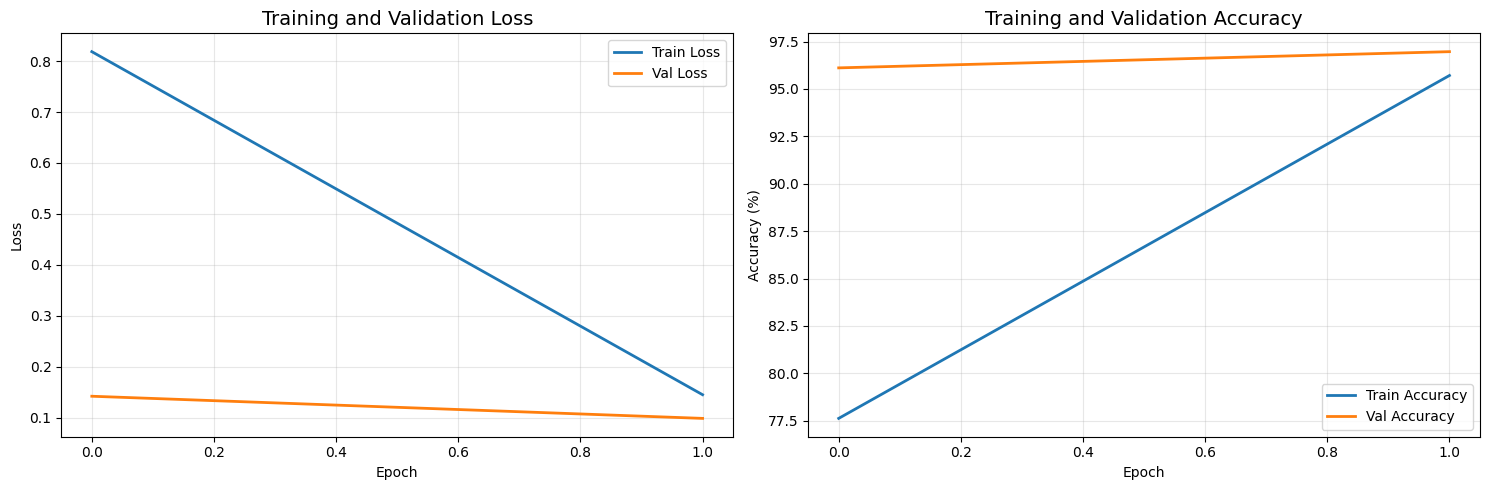


Evaluating on test set...


Testing: 100%|██████████| 198/198 [01:31<00:00,  2.17it/s]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class_0      1.000     0.967     0.983        60
     Class_1      0.950     0.994     0.972       720
     Class_2      0.984     0.989     0.987       750
     Class_3      1.000     0.876     0.934       450
     Class_4      0.986     0.992     0.989       660
     Class_5      0.931     0.967     0.949       630
     Class_6      1.000     0.913     0.955       150
     Class_7      0.899     0.993     0.944       450
     Class_8      0.998     0.938     0.967       450
     Class_9      0.962     0.992     0.976       480
    Class_10      0.991     0.997     0.994       660
    Class_11      0.980     0.952     0.966       420
    Class_12      0.964     0.964     0.964       690
    Class_13      0.992     0.992     0.992       720
    Class_14      1.000     1.000     1.000       270
    Class_15      0.991     0.995     0.993       210
    Class_16      1.000     0.993     0.997       150
    

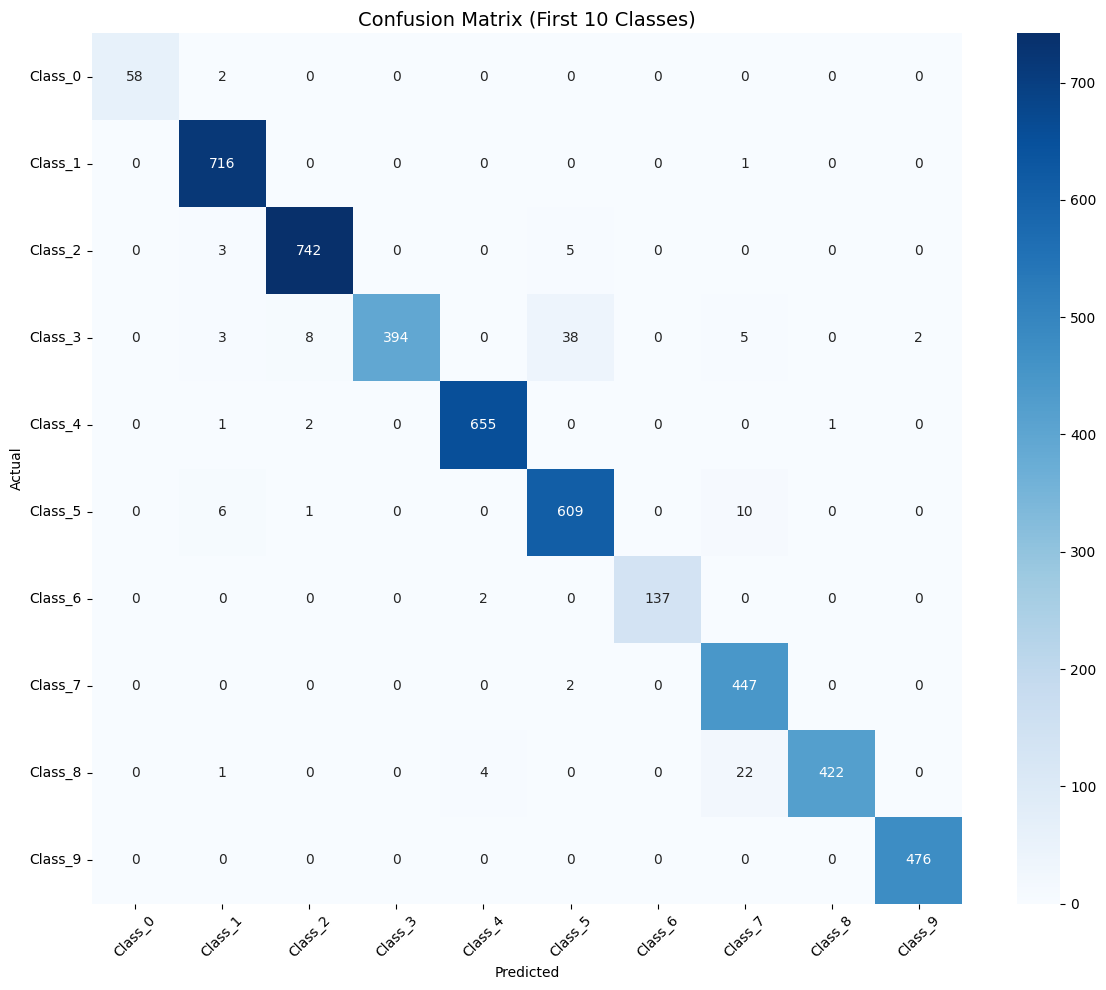


Overall Test Accuracy: 95.79%

Visualizing sample predictions...


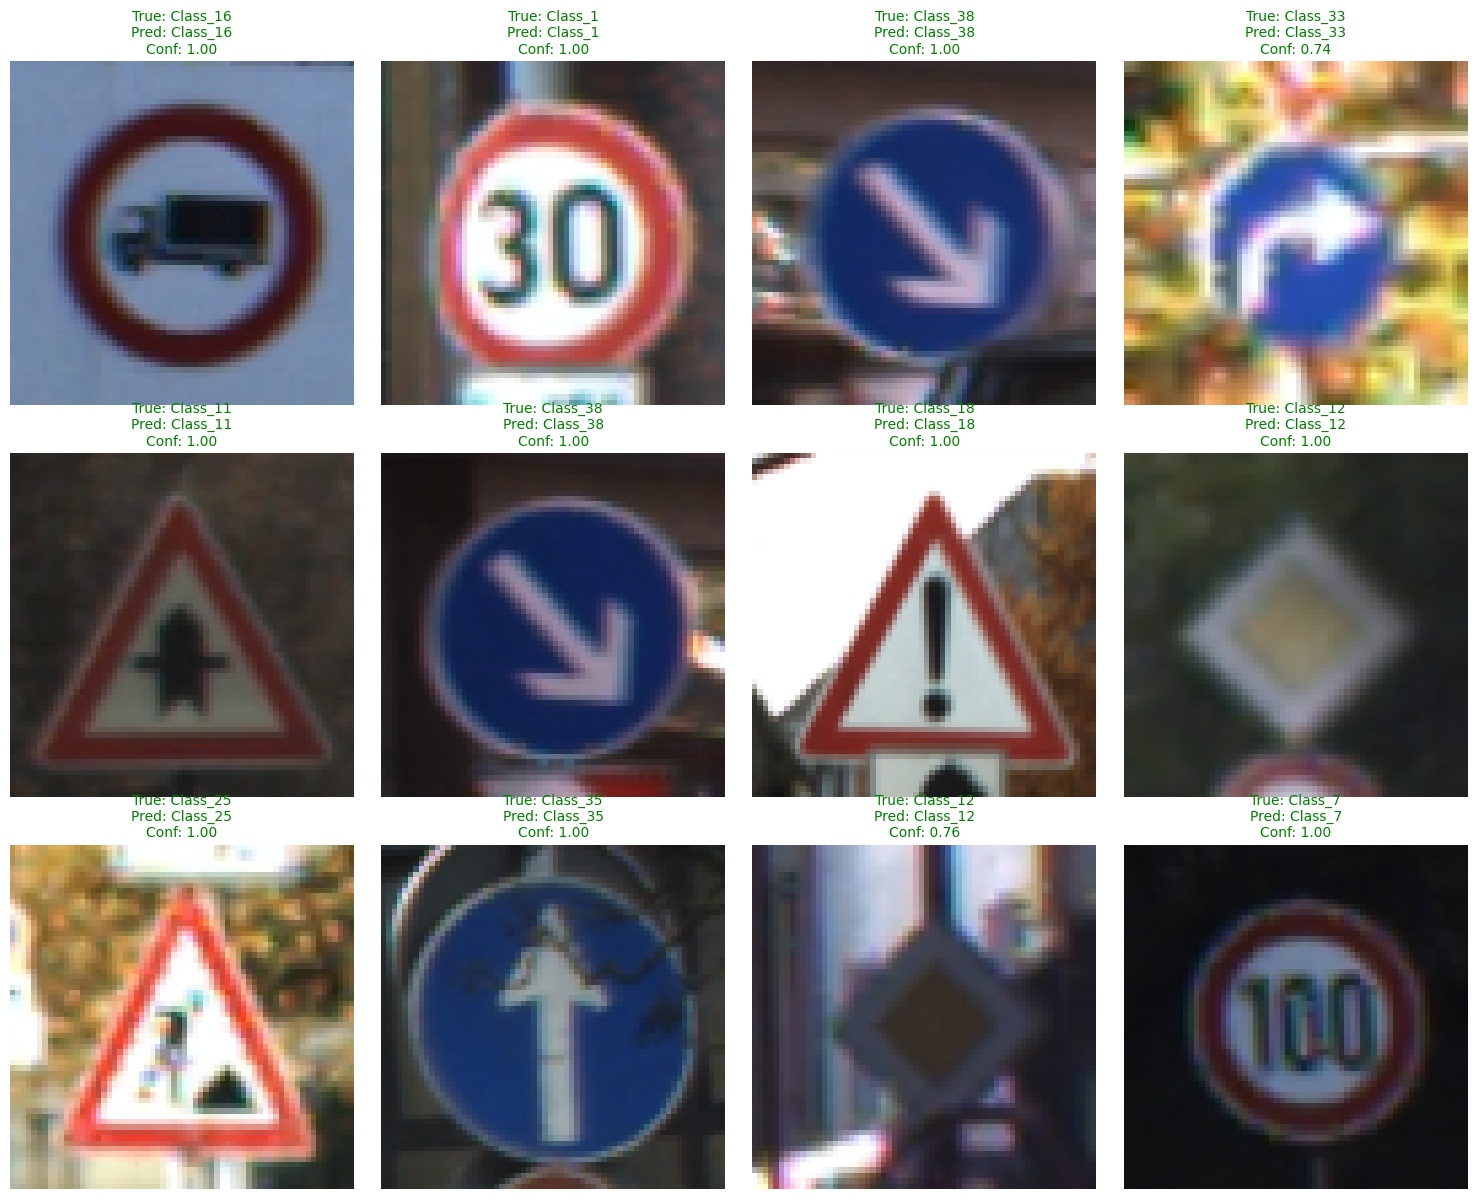


✅ Model saved with 95.79% test accuracy!
📁 Model file: gtsrb_traffic_sign_model.pth

PROJECT SUMMARY
📊 Dataset: GTSRB (German Traffic Sign Recognition Benchmark)
🎯 Classes: 43 traffic sign types
📈 Final Test Accuracy: 95.79%
💾 Model saved for future use


In [15]:
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Dataset path - UPDATE THIS TO YOUR PATH
    data_path = download_gtsrb_from_kaggle()

    # Explore dataset first
    explore_dataset(data_path)

    # Data transforms
    train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(0.3),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    test_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    print("\nLoading datasets...")
    try:
        train_dataset = GTSRBDataset(data_path, 'train', train_transforms)
        test_dataset = GTSRBDataset(data_path, 'test', test_transforms)

        # Get class names from dataset
        class_names = train_dataset.class_names

        # Split train into train/validation
        train_size = int(0.8 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_subset, val_subset = torch.utils.data.random_split(
            train_dataset, [train_size, val_size]
        )

        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

        print(f"Training samples: {len(train_loader.dataset)}")
        print(f"Validation samples: {len(val_loader.dataset)}")
        print(f"Test samples: {len(test_loader.dataset)}")

    except Exception as e:
        print(f"Error loading datasets: {e}")
        print("Trying alternative loading method...")
        return

    # Create model
    print("\nInitializing model...")
    model = TrafficSignCNN(num_classes=43)

    # Print model summary
    print(f"Model architecture:")
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Train model
    trainer = TrafficSignTrainer(model, train_loader, val_loader, device)
    trainer.train(epochs=2)

    # Plot training history
    plot_training_history(trainer)

    # Evaluate on test set
    print("\nEvaluating on test set...")
    all_preds, all_labels, accuracy, probabilities = evaluate_model(
        model, test_loader, device, class_names
    )

    # Visualize sample predictions
    print("\nVisualizing sample predictions...")
    visualize_sample_predictions(model, test_loader, device, class_names)

    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'accuracy': accuracy,
        'class_names': class_names,
        'model_architecture': 'TrafficSignCNN'
    }, 'gtsrb_traffic_sign_model.pth')

    print(f"\nModel saved with {accuracy:.2f}% test accuracy!")
    print(f"Model file: gtsrb_traffic_sign_model.pth")

    # Print some final statistics
    print("\n" + "="*60)
    print("PROJECT SUMMARY")
    print("="*60)
    print(f"Dataset: GTSRB (German Traffic Sign Recognition Benchmark)")
    print(f"Classes: {len(class_names)} traffic sign types")
    print(f"Final Test Accuracy: {accuracy:.2f}%")
    print(f"Model saved for future use")
    print("="*60)

if __name__ == "__main__":
    main()